<a href="https://colab.research.google.com/github/aniketsharma00411/ML-Zoomcamp/blob/main/Session%202/Session%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Session #2 Homework

https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/02-regression/homework.md

### Initialization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

### Dataset

In this homework, we will use the New York City Airbnb Open Data. You can take it from
[Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

The goal of this homework is to create a regression model for prediction apartment prices (column `'price'`).

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-09-17 09:06:35--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv’

AB_NYC_2019.csv     100%[===================>]   6.75M  --.-KB/s    in 0.05s   

2021-09-17 09:06:35 (139 MB/s) - ‘AB_NYC_2019.csv’ saved [7077973/7077973]



### EDA

* Load the data.
* Look at the `price` variable. Does it have a long tail?

In [3]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


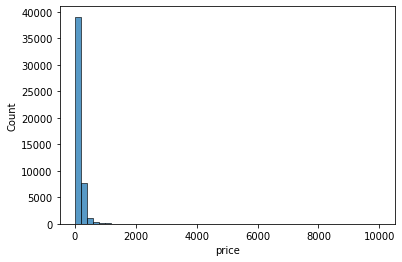

In [4]:
sns.histplot(data.price, bins=50)

The `price` variable does have a long tail.

### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'price'`,
* `'minimum_nights'`,
* `'number_of_reviews'`,
* `'reviews_per_month'`,
* `'calculated_host_listings_count'`,
* `'availability_365'`

Select only them.

In [5]:
features = [
    'latitude',
    'longitude',
    'price',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

In [6]:
data = data[features]

### Question 1

Find a feature with missing values. How many missing values does it have?

In [7]:
data.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

The `reviews_per_month` feature has **10052** missing values.

### Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

In [8]:
data.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

The 50% percentile is **3**.

### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

In [9]:
np.random.seed(42)
index = list(data.index)
np.random.shuffle(index)

In [10]:
samples = data.shape[0]

num_val = int(samples*0.2)
num_test = int(samples*0.2)
num_train = int(samples-(num_val+num_test))

samples, num_train, num_val, num_test

(48895, 29337, 9779, 9779)

In [11]:
X_train = data.iloc[index[:num_train]].reset_index(drop=True)
y_train = np.log1p(X_train.price)
del X_train['price']
X_val = data.iloc[index[num_train:num_train+num_val]].reset_index(drop=True)
y_val = np.log1p(X_val.price)
del X_val['price']
X_test = data.iloc[index[num_train+num_val:]].reset_index(drop=True)
y_test = np.log1p(X_test.price)
del X_test['price']

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lesssons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [12]:
def prepare_X(df, val):
    df = df.copy()

    df = df.fillna(val)
    X = df.values
    
    return X


def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


def rmse(y, y_pred):
    se = (y - y_pred)**2
    mse = se.mean()

    return np.sqrt(mse)

#### Filling with 0

In [13]:
X_train_updated = prepare_X(X_train, val=0)
w0, w = train_linear_regression(X_train_updated, y_train)

X_val_updated = prepare_X(X_val, val=0)
y_pred = w0 + X_val_updated@w

score = rmse(y_val, y_pred)
round(score, 2)

0.64

#### Filling with mean

In [14]:
X_train_updated = prepare_X(X_train, val=X_train.reviews_per_month.mean())
w0, w = train_linear_regression(X_train_updated, y_train)

X_val_updated = prepare_X(X_val, val=X_train.reviews_per_month.mean())
y_pred = w0 + X_val_updated@w

score = rmse(y_val, y_pred)
round(score, 2)

0.64

Both the options gave equally good RMSE.

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [15]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [16]:
scores = []
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train_updated = prepare_X(X_train, val=0)
    w0, w = train_linear_regression_reg(X_train_updated, y_train, r=r)

    X_val_updated = prepare_X(X_val, val=0)
    y_pred = w0 + X_val_updated@w

    score = rmse(y_val, y_pred)
    scores.append(round(score, 2))

scores

[0.64, 0.64, 0.64, 0.64, 0.66, 0.68, 0.68, 0.68, 0.68]

`r=0` gives the best RMSE. So, there is no need for regularization in this problem.

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)


> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [17]:
scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    index = list(data.index)
    np.random.shuffle(index)

    num_val = int(samples*0.2)
    num_test = int(samples*0.2)
    num_train = int(samples-(num_val+num_test))

    X_train = data.iloc[index[:num_train]].reset_index(drop=True)
    y_train = np.log1p(X_train.price)
    del X_train['price']
    X_val = data.iloc[index[num_train:num_train+num_val]].reset_index(drop=True)
    y_val = np.log1p(X_val.price)
    del X_val['price']
    X_test = data.iloc[index[num_train+num_val:]].reset_index(drop=True)
    y_test = np.log1p(X_test.price)
    del X_test['price']

    X_train_updated = prepare_X(X_train, val=0)
    w0, w = train_linear_regression(X_train_updated, y_train)

    X_val_updated = prepare_X(X_val, val=0)
    y_pred = w0 + X_val_updated@w

    score = rmse(y_val, y_pred)
    scores.append(score)

scores

[0.6549779961157265,
 0.6462523685787196,
 0.6476558177163435,
 0.6375145071233633,
 0.6445809083551752,
 0.6305809996077186,
 0.6297851917617099,
 0.6506184267164323,
 0.6489780353432691,
 0.6437565168302605]

In [18]:
std = np.std(scores)
round(std, 3)

0.008

The standard deviation is **0.008** which is low and thus it can be concluded that the model trained is stable.

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Train a model with `r=0.001`.
* What's the RMSE on the test dataset?

In [19]:
np.random.seed(9)
index = list(data.index)
np.random.shuffle(index)

num_val = int(samples*0.2)
num_test = int(samples*0.2)
num_train = int(samples-(num_val+num_test))

X_train = data.iloc[index[:num_train]].reset_index(drop=True)
y_train = np.log1p(X_train.price)
del X_train['price']
X_val = data.iloc[index[num_train:num_train+num_val]].reset_index(drop=True)
y_val = np.log1p(X_val.price)
del X_val['price']
X_test = data.iloc[index[num_train+num_val:]].reset_index(drop=True)
y_test = np.log1p(X_test.price)
del X_test['price']

X_full = pd.concat((X_train, X_val))
y_full = list(y_train)+list(y_val)

X_full_updated = prepare_X(X_full, val=0)
w0, w = train_linear_regression_reg(X_full_updated, y_full, r=0.001)

X_test_updated = prepare_X(X_test, val=0)
y_pred = w0 + X_test_updated@w

score = rmse(y_test, y_pred)
score

0.6452771348554619

The RMSE on test dataset is **0.65**.